In [6]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import glob
import pandas as pd
from scipy.io import arff
import logging
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from tools.clustering.fuzzy_cmeans import FuzzyCMeansParamsGrid
from tools.config import DATA_DIR, CLUSTERED_DATA_DIR

# Set up logger
logger = logging.getLogger(__name__)

In [7]:
CLUSTERED_DATA_DIR
model_name = 'fuzzy_cmeans'
dataset_name = 'synthetic'

In [8]:
SCRIPT_DIR = pathlib.Path(os.getcwd()).absolute()
DATA_DIR = os.path.join(SCRIPT_DIR.parent, "data")
PREPROCESSED_DATA_DIR = f'{DATA_DIR}/1_preprocessed/'

In [9]:
data_path = f"{DATA_DIR}/1_preprocessed/synthetic.csv"
df  = pd.read_csv(data_path)
df['class'].unique()


array([1, 2, 4, 3, 0])

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

METRICS_FILE_PATH = f"{DATA_DIR}/3_metrics.csv"
data = pd.read_csv(METRICS_FILE_PATH)

# Ensure numerical columns are properly parsed (if needed)
data['runtime'] = pd.to_numeric(data['runtime'], errors='coerce')
data['ari'] = pd.to_numeric(data['ari'], errors='coerce')
data['purity'] = pd.to_numeric(data['purity'], errors='coerce')
data['dbi'] = pd.to_numeric(data['dbi'], errors='coerce')
data['f_measure'] = pd.to_numeric(data['f_measure'], errors='coerce')

data

,dataset,model,runtime,ari,purity,dbi,f_measure,n_clusters,fuzzyness,max_iterations,...,random_state,strictness,min_obs,max_depth,metric,algorithm,n_neighbors,affinity,eigen_solver,assign_labels
0,hepatitis,fuzzy_cmeans,0.002671,0.047810,0.316129,2.029871,0.083925,10.0,1.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hepatitis,fuzzy_cmeans,0.011547,0.045040,0.245161,2.081026,0.084667,10.0,2.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,hepatitis,fuzzy_cmeans,0.006676,0.087688,0.329032,1.879722,0.100027,10.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,hepatitis,fuzzy_cmeans,0.006717,0.034207,0.212903,2.189391,0.076966,10.0,3.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,hepatitis,fuzzy_cmeans,0.009183,0.038980,0.251613,1.929497,0.079825,10.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2796,vowel,spectral_clustering,0.049719,0.028985,0.303030,4.249091,0.146672,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,nearest_neighbors,lobpcg,kmeans
2797,vowel,spectral_clustering,0.358995,-0.006860,0.266667,1.230998,0.071318,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,rbf,arpack,cluster_qr
2798,vowel,spectral_clustering,0.491837,-0.006860,0.266667,1.230998,0.071318,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,rbf,arpack,kmeans
2799,vowel,spectral_clustering,0.086160,-0.006860,0.266667,1.230998,0.071318,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,rbf,lobpcg,cluster_qr


In [ ]:
def plot_model_comparisons(data, metric, title):
    """
    Plot comparisons of models across datasets based on a given metric.
    
    Args:
        data (pd.DataFrame): The dataset containing performance metrics.
        metric (str): The metric to visualize (e.g., 'ari', 'purity').
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=data, 
        x='dataset', 
        y=metric, 
        hue='model', 
        ci='sd', 
        palette='viridis'
    )
    plt.title(title, fontsize=14)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.legend(title='Model', fontsize=10, loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



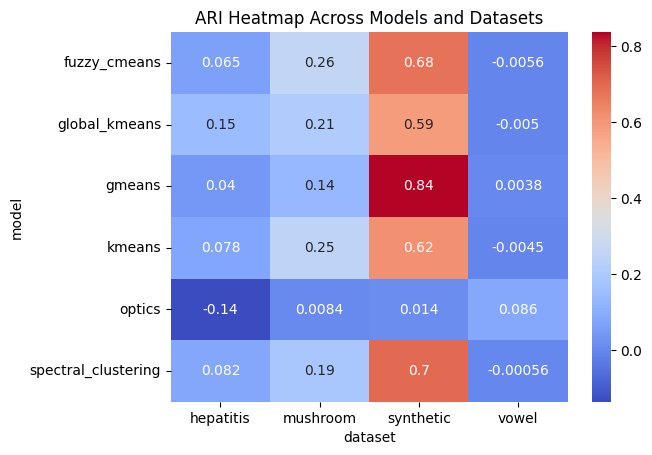

In [21]:
def plot_heatmaps(data):
    pivot_table = data.pivot_table(
        index='model', columns='dataset', values='ari', aggfunc='mean'
    )
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
    plt.title('ARI Heatmap Across Models and Datasets')
    plt.show()

plot_heatmaps(data)

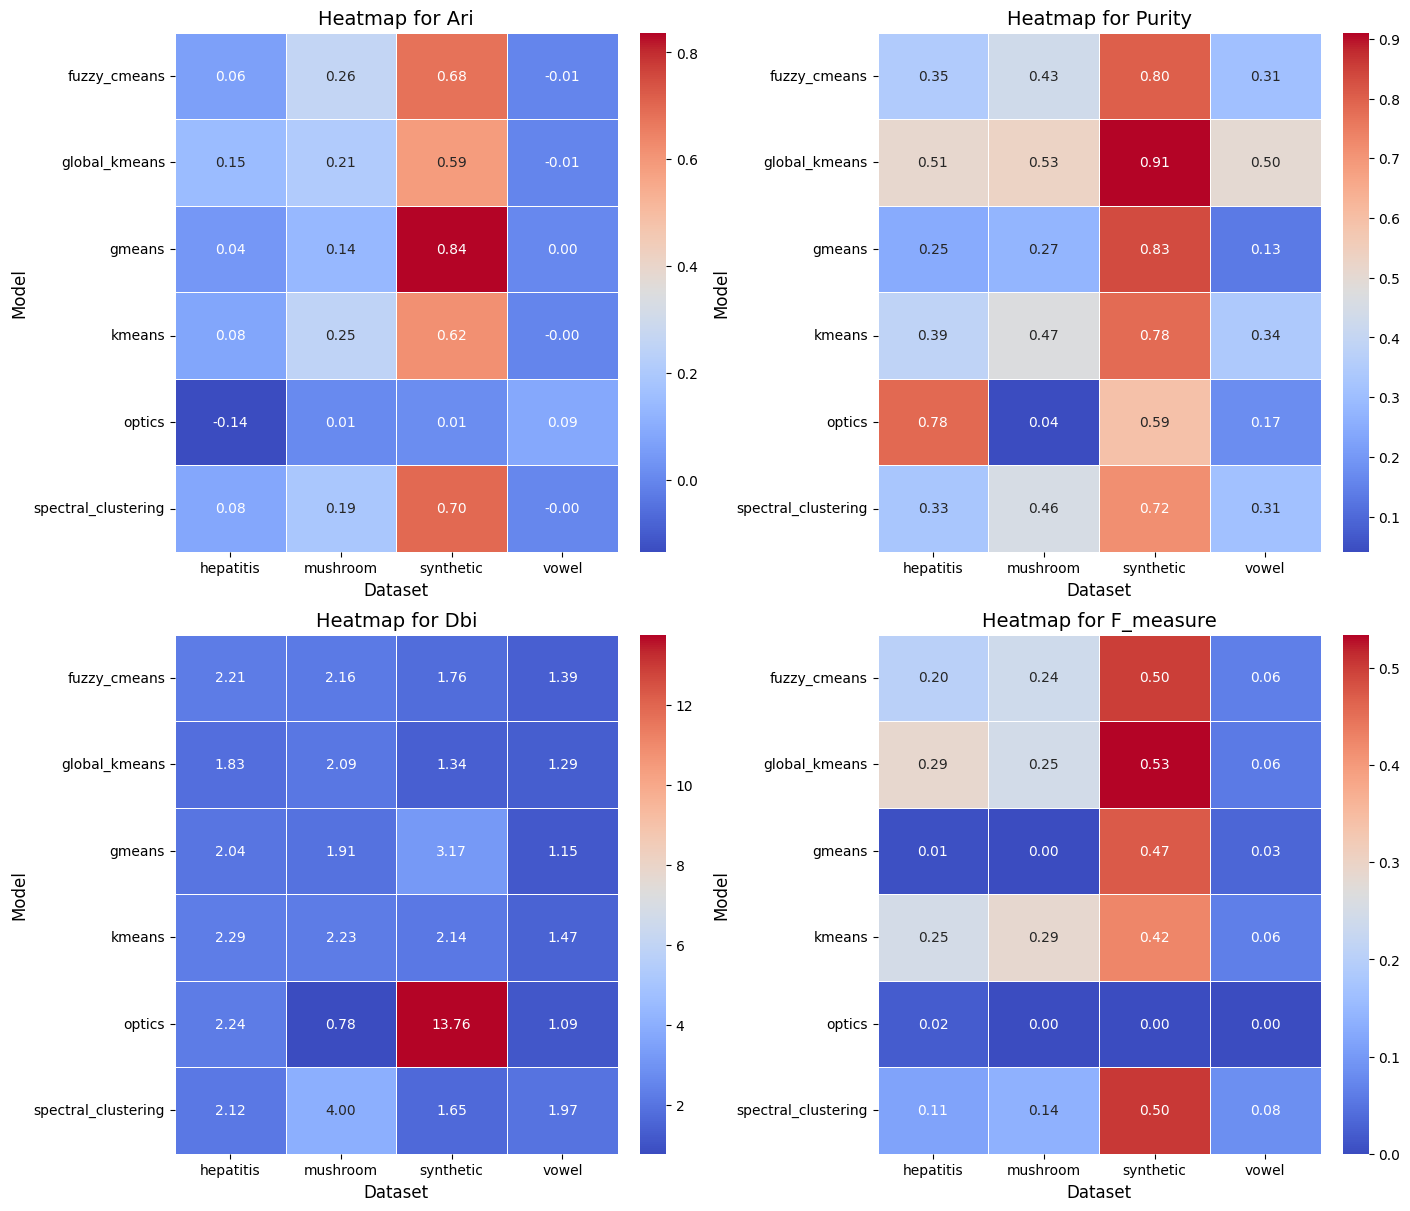

In [30]:
def plot_combined_heatmaps(data, metrics, datasets, models):
    """
    Generate a grid of heatmaps (e.g., 2x2) for multiple metrics.
    
    Args:
        data (pd.DataFrame): The dataset containing performance metrics.
        metrics (list): List of metrics to plot heatmaps for.
        datasets (list): List of dataset names.
        models (list): List of model names.
    """
    n_metrics = len(metrics)
    n_cols = 2  # Number of columns for the heatmap grid
    n_rows = (n_metrics + n_cols - 1) // n_cols  # Calculate rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6 * n_rows), constrained_layout=True)
    
    # Flatten axes to easily iterate over them, even for 2D array
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        # Pivot table for the heatmap
        pivot_table = data.pivot_table(
            index='model', columns='dataset', values=metric, aggfunc='mean'
        ).reindex(index=models, columns=datasets)  # Ensure consistent order
        
        # Plot the heatmap on the respective subplot
        sns.heatmap(
            pivot_table,
            ax=axes[i],
            annot=True,
            cmap='coolwarm',
            cbar=True,
            linewidths=0.5,
            fmt=".2f",
        )
        axes[i].set_title(f'Heatmap for {metric.capitalize()}', fontsize=14)
        axes[i].set_xlabel('Dataset', fontsize=12)
        axes[i].set_ylabel('Model', fontsize=12)
    
    # Hide any unused subplots (in case metrics < n_rows * n_cols)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

# Example usage:
# Define the metrics, datasets, and models to compare
metrics = ['ari', 'purity', 'dbi', 'f_measure']
datasets = data['dataset'].unique()
models = data['model'].unique()

# Generate the combined heatmaps
plot_combined_heatmaps(data, metrics, datasets, models)


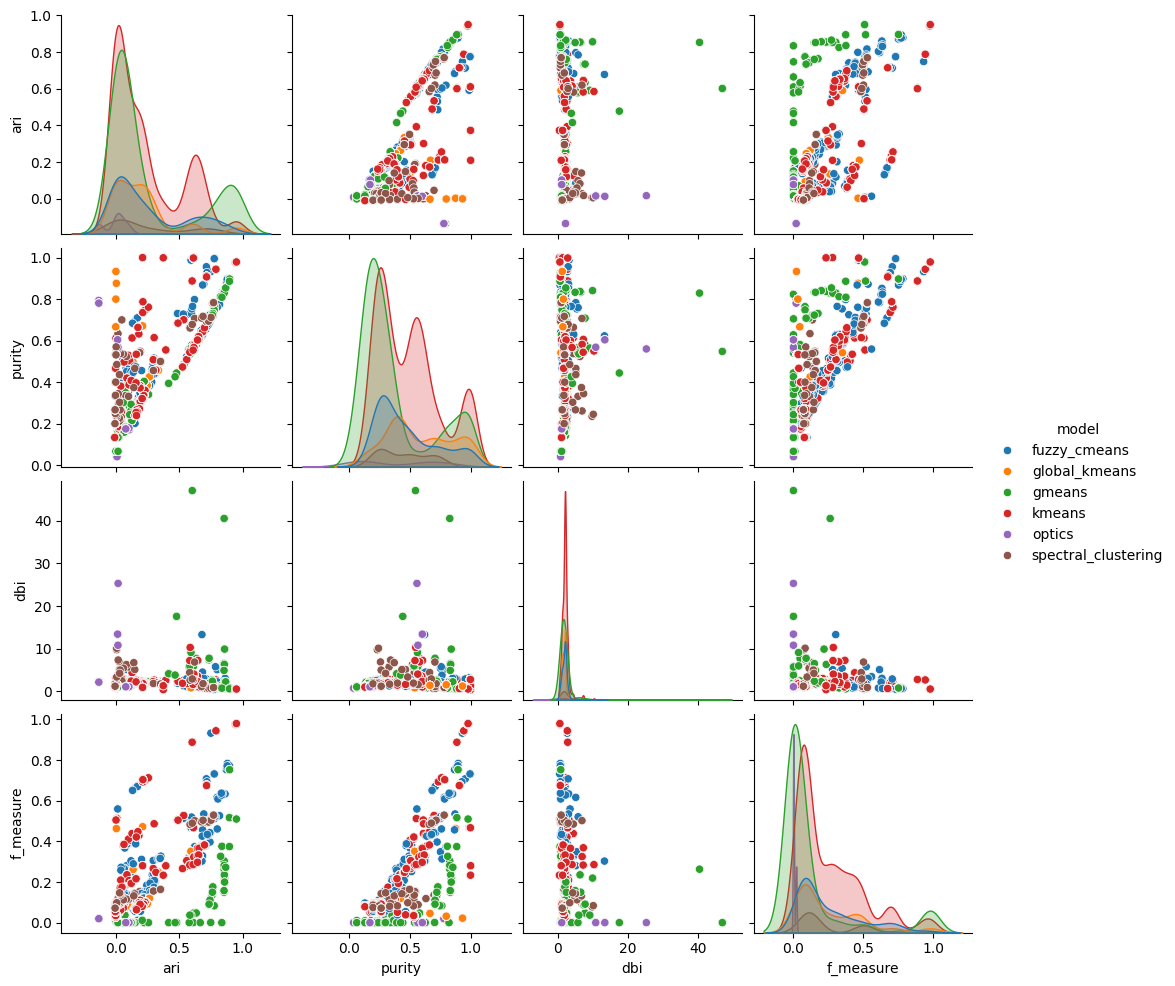

In [22]:

def plot_pairplot(data):
    sns.pairplot(data, vars=['ari', 'purity', 'dbi', 'f_measure'], hue='model')
    plt.show()

plot_pairplot(data)

/tmp/ipykernel_66421/637982909.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


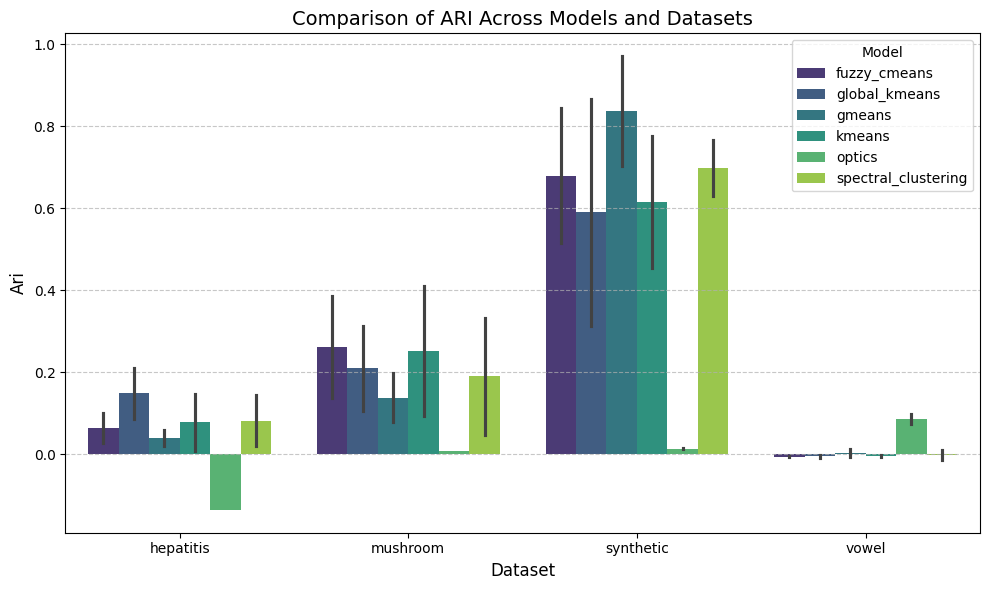

In [ ]:
# Compare ARI
plot_model_comparisons(data, 'ari', 'Comparison of ARI Across Models and Datasets')

/tmp/ipykernel_66421/637982909.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


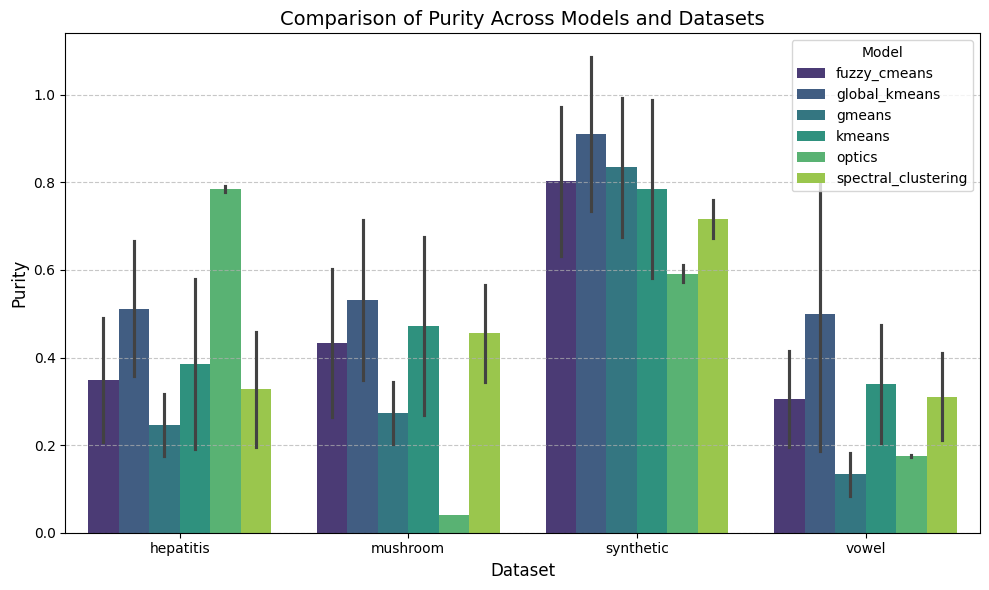

In [13]:
# Compare Purity
plot_model_comparisons(data, 'purity', 'Comparison of Purity Across Models and Datasets')



/tmp/ipykernel_66421/637982909.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


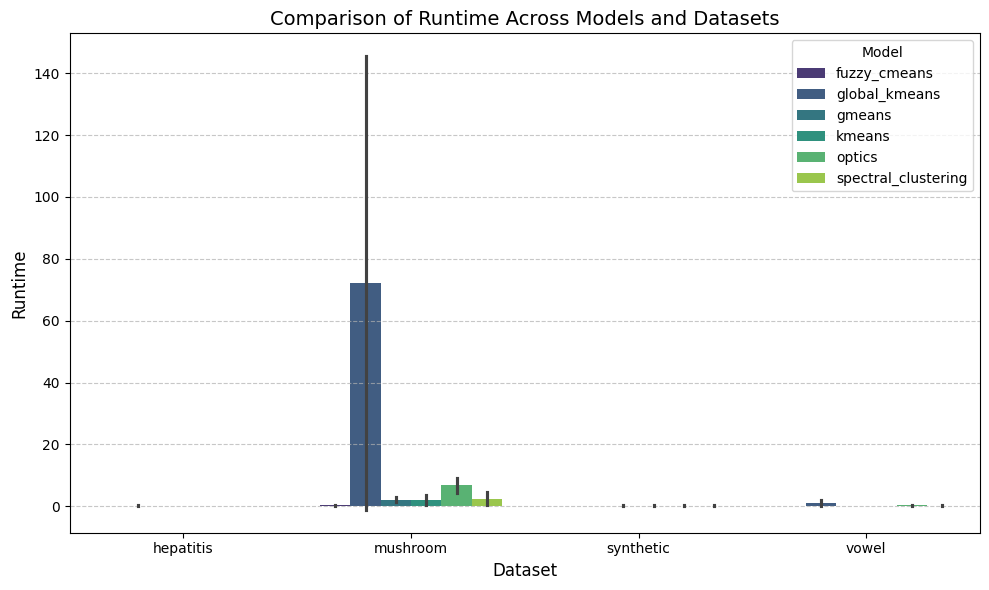

In [14]:
# Compare Runtime
plot_model_comparisons(data, 'runtime', 'Comparison of Runtime Across Models and Datasets')


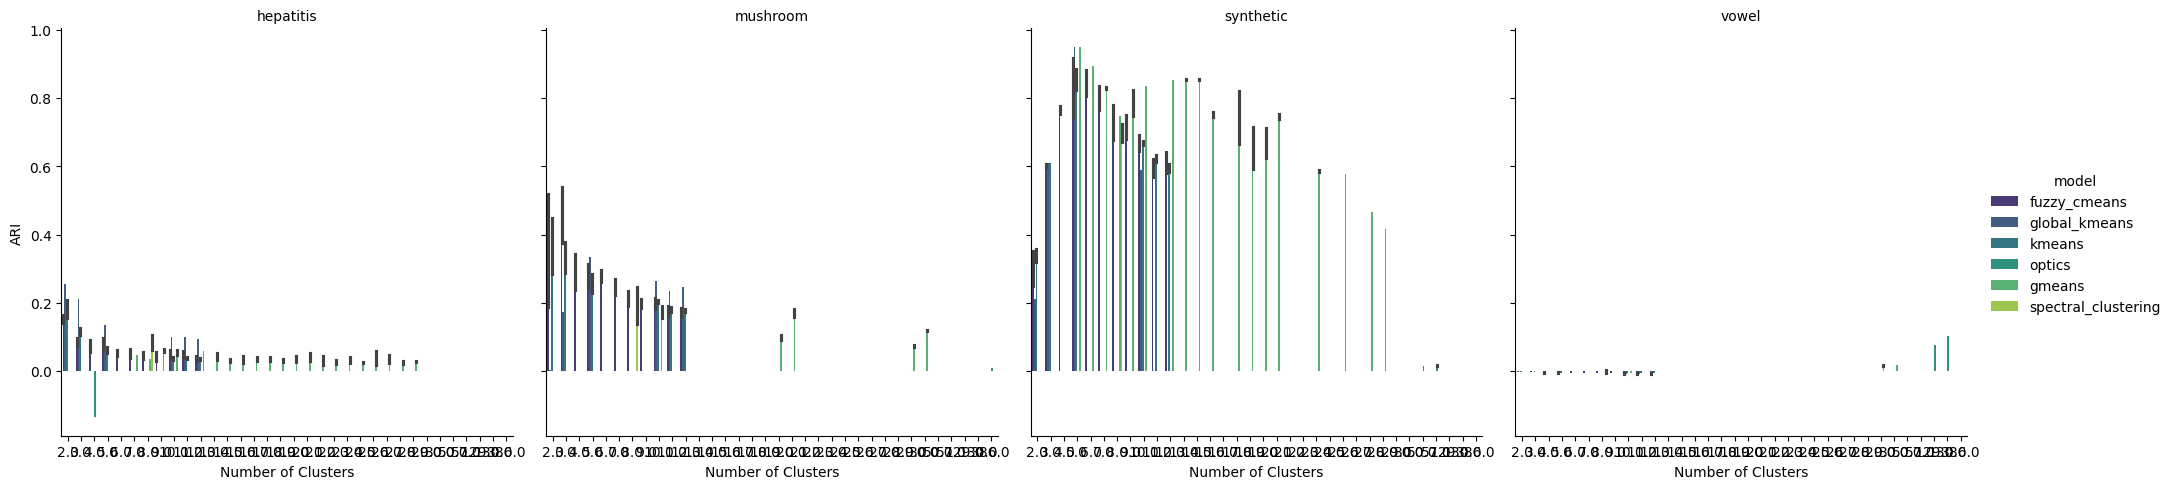

In [20]:
def compare_clustering_params(data):
    g = sns.catplot(
        data=data, 
        x='n_clusters', 
        y='ari', 
        hue='model', 
        col='dataset', 
        kind='bar', 
        palette='viridis'
    )
    g.set_titles("{col_name}")
    g.set_axis_labels("Number of Clusters", "ARI")
    plt.show()

compare_clustering_params(data)

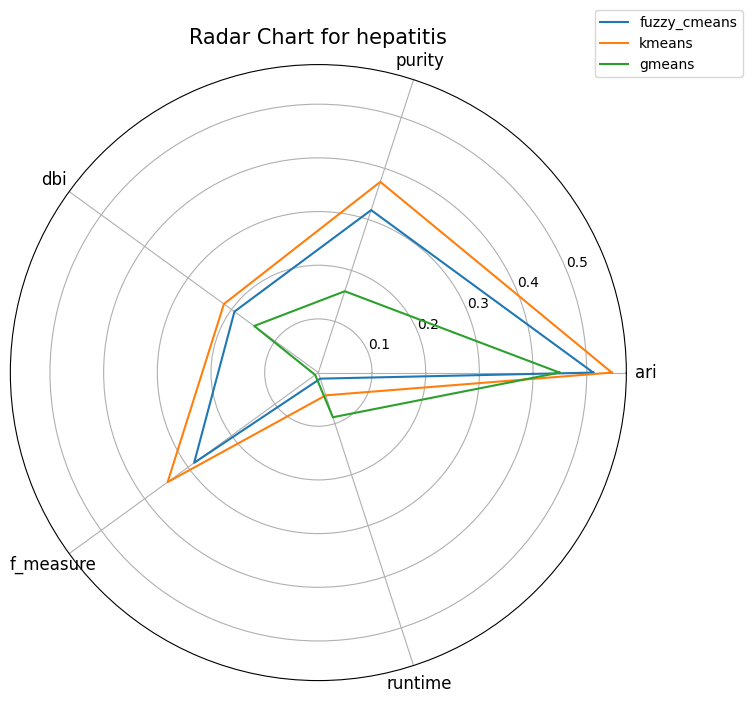

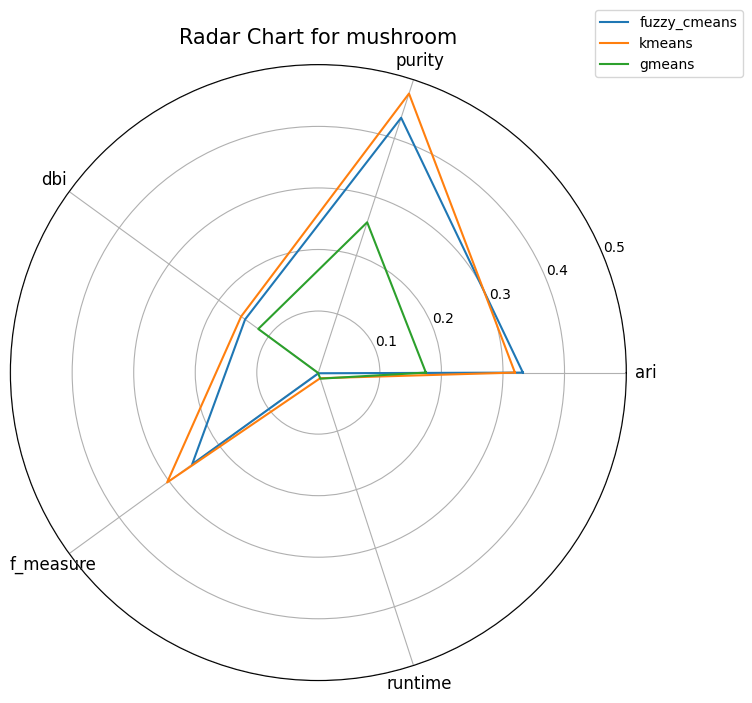

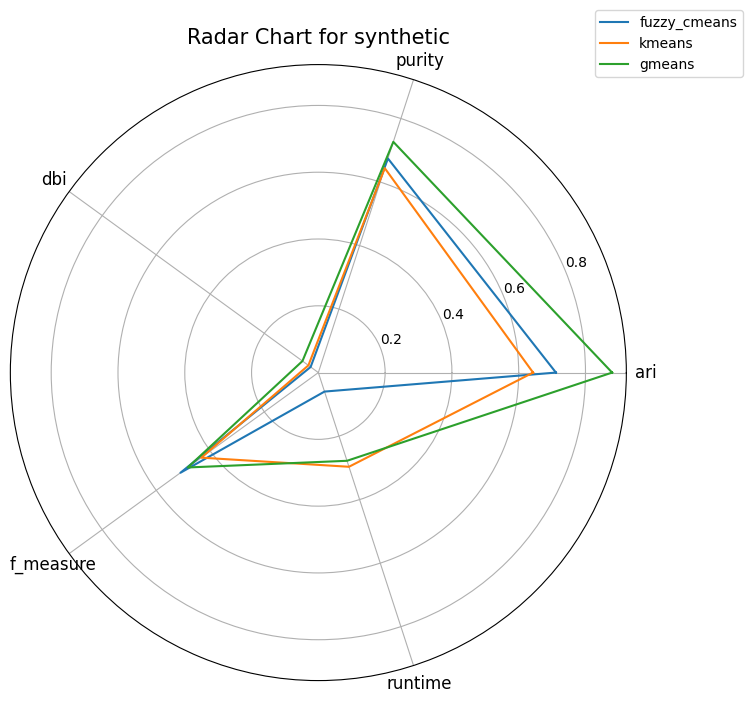

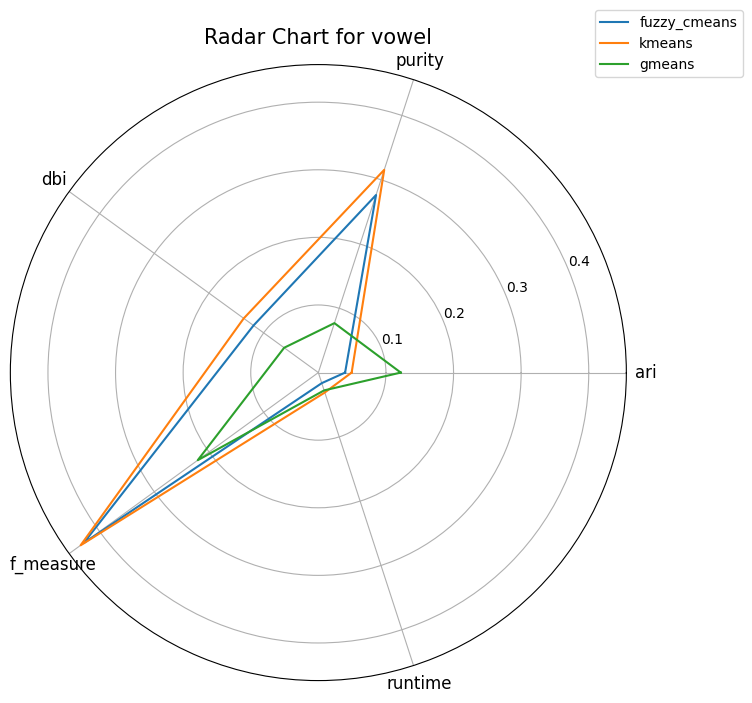

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_chart(data, dataset_name, metrics, models):
    """
    Generate radar chart to visualize multiple metrics for each model.
    
    Args:
        data (pd.DataFrame): The dataset containing performance metrics.
        dataset_name (str): The name of the dataset to filter by.
        metrics (list): List of metrics to include in the radar chart.
        models (list): List of models to compare.
    """
    # Filter data for the selected dataset
    subset = data[data['dataset'] == dataset_name]
    
    # Normalize metrics to make them comparable (optional but recommended)
    normalized_data = subset.copy()
    for metric in metrics:
        max_value = subset[metric].max()
        min_value = subset[metric].min()
        normalized_data[metric] = (subset[metric] - min_value) / (max_value - min_value)
    
    # Prepare data for radar chart
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    plt.figure(figsize=(8, 8))
    
    for model in models:
        model_data = normalized_data[normalized_data['model'] == model]
        if not model_data.empty:
            # Extract metric values
            values = model_data[metrics].mean().tolist()
            values += values[:1]  # Complete the circle
            
            # Plot data
            plt.polar(angles, values, label=model)
    
    # Draw one axis per metric
    plt.xticks(angles[:-1], metrics, fontsize=12)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.title(f'Radar Chart for {dataset_name}', fontsize=15)
    
    # Show plot
    plt.show()

# Example usage:
# Define the metrics and models to compare
metrics = ['ari', 'purity', 'dbi', 'f_measure', 'runtime']
models = ['fuzzy_cmeans', 'kmeans', 'gmeans']

# Generate radar chart for each dataset
datasets = data['dataset'].unique()
for dataset in datasets:
    plot_radar_chart(data, dataset, metrics, models)
